<a href="https://colab.research.google.com/github/cagBRT/Machine-Learning/blob/master/FeatureSelection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# Clone the entire repo.
!git clone -l -s https://github.com/cagBRT/Machine-Learning.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 901 (delta 10), reused 3 (delta 1), pack-reused 878
Receiving objects: 100% (901/901), 51.51 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (563/563), done.
/content/cloned-repo/cloned-repo
 Admission_Predict.csv		       Logistic_Regression_3.ipynb
 bank.csv			       Logistic_Regression_4.ipynb
 bank-full.csv			       LogReg_Titanic.ipynb
 blue_line.jpg			       Mall_Customers.csv
 boston_housing.csv		       movies_df.csv
 breast_cancer_data.csv		       NaiveBayesBernoulli.ipynb
 cardata.data			       NaiveBayesGaussian2.ipynb
 cows_and_wolves.txt		       NaiveBayesGaussian.ipynb
 CrossValidation.ipynb		       NaiveBayesMultinomialNB2.ipynb
 datasets_478_974_mushrooms.csv        NaiveBayesMultinomialNB.ipynb
 diabetesML.ipynb		       naiveBayes.png
 dogOrMuffin.ipynb		       PCA0.ipynb
 fashion-mnist-sprite.pn

# **Remove features with low variance**

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Any data where 80% of the data is the same is considered low variance data. <br>

Features with a training-set variance lower than this threshold will be removed. <br>
**The default is to keep all features with non-zero variance**, i.e. remove the features that have the same value in all samples.


Create a datasest with 3 features

In [84]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
print(X)

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]


Remove all variables where the variance does not meet the threshold

As expected, VarianceThreshold has removed the first column, 
which had 0,0,1,0,0,0 <br>
There is very little variance in this column, so it will not add much information for our model to use when making predictions. So remove this column.  

In [100]:
sel = VarianceThreshold(threshold=(0.16))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

# **Assignment 1**
Remove any low variance data from the given dataset.<br>
<br>
[[0,1,2,0,2],[2,2,1,0,1],[1,1,1,0,1],[0,2,1,0,0],[2,1,1,0,0],[1,1,2,0,0],[2,2,0,0,1],[1,0,1,0,1],[0,2,1,0,1],[2,1,1,1,0],[0,1,1,0,2],[1,2,0,0,1],[2,1,1,2,1],[2,0,1,0,1]]

1. Find the lowest threshold that still produces a change in the dataset
2. Find the threshold to remove a second feature column

In [101]:
#Assignment 1
xx = [[0,1,2,0,2],[2,2,1,0,1],[1,1,1,0,1],[0,2,1,0,0],[2,1,1,0,0],[1,1,2,0,0],[2,2,0,0,1],[1,0,1,0,1],[0,2,1,0,1],[2,1,1,1,0],[0,1,1,0,2],[1,2,0,0,1],[2,1,1,0,1],[2,0,1,0,1]]


# **Univariate feature selection**

>SelectKBest removes all but the k highest scoring features<br>
<br>
SelectPercentile removes all but a user-specified highest scoring percentage of features<br>
<br>
Uses common univariate statistical tests for each feature:<br> 
* false positive rate SelectFpr<br>
* false discovery rate SelectFdr<br>
* family wise error SelectFwe<br>
* genericUnivariateSelect - selects the best strategy with a hyper parameter search estimator

**Example 1:**

SelectKBest removes all but the *k* highest scoring features

Get the Iris dataset

In [102]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

These functions take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile)<br>
For regression use: f_regression, mutual_info_regression

For classification use: chi2, f_classif, mutual_info_classif
<br><br>
Then select the highest scoring features

In [104]:
#Use chi2 to score the the columns. Select the two columns that have the highest scores
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

**Example 2: Check model performance after variable selection**

In [105]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

**Get data and add noise to the dataset**

As an experiment, use the Iris dataset, but add noise to it so that it has 24 features. 

In [106]:
# Import the Iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))
X.shape


(150, 24)

**Do the train-test split**

In [107]:
# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

**Create an SVM model and train it on all the features**

In [108]:
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.789


**Create an SVM and train it with only the selected features**

In [109]:
#X_indices = np.arange(X.shape[-1])

# #############################################################################
#Using the SelectKBest function, select the best 4 best features to keep
# #############################################################################

selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [110]:
clf_selected = make_pipeline(
        SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.868


It is clear the model that used only the highest scoring SelectKBest values has a higher performance. 

<Figure size 432x288 with 0 Axes>

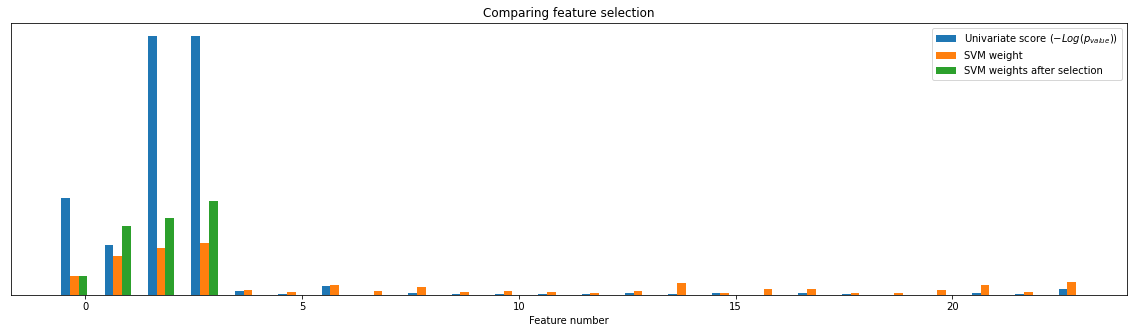

In [112]:
plt.figure(1)
plt.figure(figsize=(20,5))
plt.clf()

plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight')

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

# **Assignment 2**
The plot above shows two of the univariate scores are much higher that the other scores. <br>
Train the model using only the two highest scores. <br>
Does the model performance get better or worse?

In [ ]:
#Assignment 2


# **Recursive feature elimination**

Select features by recursively considering smaller and smaller sets of features


A recursive feature elimination example showing the relevance of pixels in a digit classification task

In [93]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**Load the digits dataset (classification)**.<br>

Each datapoint is a 8x8 image of a digit.<br>
>Classes: 10<br>
>Samples per class: ~180<br>
>Samples total: 1797<br>
>Dimensionality: 64<br>
>Features: integers 0-9

In [62]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [63]:
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

Look at one of the digits, the number 9

<Figure size 432x288 with 0 Axes>

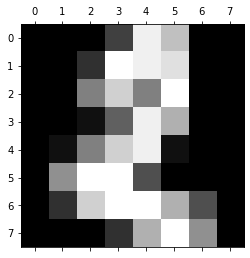

In [64]:
choice = 2
plt.gray() 
plt.matshow(digits.images[choice]) 
plt.show() 

There are 64 pixels in the image. <br>
Which ones are important to the model and which ones can we prune?

In [65]:
X[choice]

array([ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
       14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
        1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
        0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  3., 13., 16.,
       16., 11.,  5.,  0.,  0.,  0.,  0.,  3., 11., 16.,  9.,  0.])

In [66]:
y[choice]

2

Create the Recursive Feature Elimination (RFE) object and rank each pixel

In [67]:
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

List the ranks assigned to each pixel. <br>
The higher the ranking corresponds to which should be pruned first. 

In [68]:
ranking

array([[64, 50, 31, 23, 10, 17, 34, 51],
       [57, 37, 30, 43, 14, 32, 44, 52],
       [54, 41, 19, 15, 28,  8, 39, 53],
       [55, 45,  9, 18, 20, 38,  1, 59],
       [63, 42, 25, 35, 29, 16,  2, 62],
       [61, 40,  5, 11, 13,  6,  4, 58],
       [56, 47, 26, 36, 24,  3, 22, 48],
       [60, 49,  7, 27, 33, 21, 12, 46]])

Plot pixel ranking

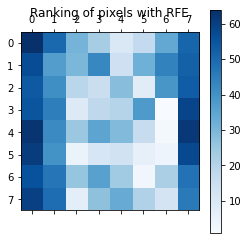

In [69]:
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

# **Assignment 3**
Right now the model is saving only one pixel. Change the number of pixels saved to 48 pixels. <br>
Rerun the ranking of the pixels. <br>
Then run the code below.<br>
Which pixels were removed? <br>
After removing the pixels compare the performance of the reduced pixel images to the performance of the full image. <br>
How much of a difference is there in the accuracy scores?

In [109]:
model = DecisionTreeClassifier()
#List of (name, transform) tuples (implementing fit/transform) that are chained, 
#in the order in which they are chained, with the last object an estimator.
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
pipeline.fit(X, y)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ValueError: ignored

In [108]:
model.fit(X, y)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ValueError: ignored

**RFE Example  2**

In [92]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

**Create the data with 3 informative features and 25 features total**

In [73]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

**Create the RFE object**<br>
Using a cross-validated score, recursively eliminate the less important features

In [74]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 3


**Plot the score vs number of features selected**

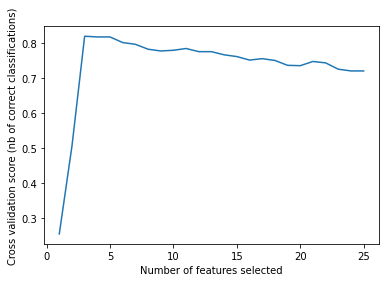

In [75]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# **Assignment 4**


In [85]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [88]:
train = pd.read_csv('featureSelectTrain.csv')
test = pd.read_csv('featureSelectTest.csv')

print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

train.head()

Train Shape:  (250, 302)
Test Shape:  (19750, 301)


,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,...,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,...,0.627,-1.472,0.496,-0.052,0.322,-0.222,1.168,0.931,-0.203,0.321,0.761,1.752,0.181,-3.029,-0.578,-0.260,-0.425,-0.160,-0.497,-0.049,1.097,0.398,0.554,0.578,-0.544,0.441,-0.524,-1.474,-0.090,-0.607,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,-0.017,-0.665,1.905,0.376,-1.373,1.587,1.464,-1.550,-0.512,0.508,-0.094,-0.114,-0.425,0.104,0.643,-1.371,1.553,-0.062,-0.173,-0.465,-1.252,0.443,2.205,-1.266,-0.739,0.827,-1.306,0.274,-1.573,...,-1.610,-0.801,1.557,0.628,-0.072,-0.573,0.507,-1.229,0.313,1.446,-0.345,1.147,-0.623,-0.048,1.456,-0.932,0.666,0.451,0.671,-0.596,-0.135,0.966,-0.167,0.530,-1.493,-0.917,0.120,0.258,-0.405,-0.859,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,-0.638,0.760,-0.360,-2.048,-0.996,-0.361,0.962,0.021,0.595,-0.943,0.069,0.483,-0.063,-0.540,-0.551,-1.736,-2.014,0.636,-1.147,-0.767,-0.678,0.815,1.696,-0.436,-1.777,0.548,0.318,0.978,1.299,...,0.011,1.137,0.499,-0.262,-1.484,0.216,-2.536,0.191,-0.142,1.387,-1.617,-0.662,-2.288,-1.130,0.651,-0.363,0.686,-0.504,1.734,-0.606,0.514,-0.506,-1.294,0.382,-1.119,1.695,-0.775,-1.428,0.231,-0.780,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,-0.499,-0.653,-0.058,-0.046,0.654,-0.697,-1.175,0.720,0.484,0.402,-1.037,1.081,0.716,-0.144,1.720,-1.980,-0.741,-1.493,-0.860,-0.082,0.133,1.084,-0.719,0.198,1.144,1.123,0.435,-0.296,-2.933,...,0.285,-0.464,1.427,0.554,-0.131,-1.425,0.487,0.413,-0.231,1.570,-0.714,0.385,-0.072,0.150,-0.228,0.144,-1.537,0.664,-0.133,0.424,0.926,-0.089,-0.415,0.299,-1.227,-2.578,0.600,2.167,-0.755,-1.265,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [98]:
# prepare for modeling
X_train_df = train.drop(['id', 'target'], axis=1)
y_train = train['target']

X_test = test.drop(['id'], axis=1)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test)

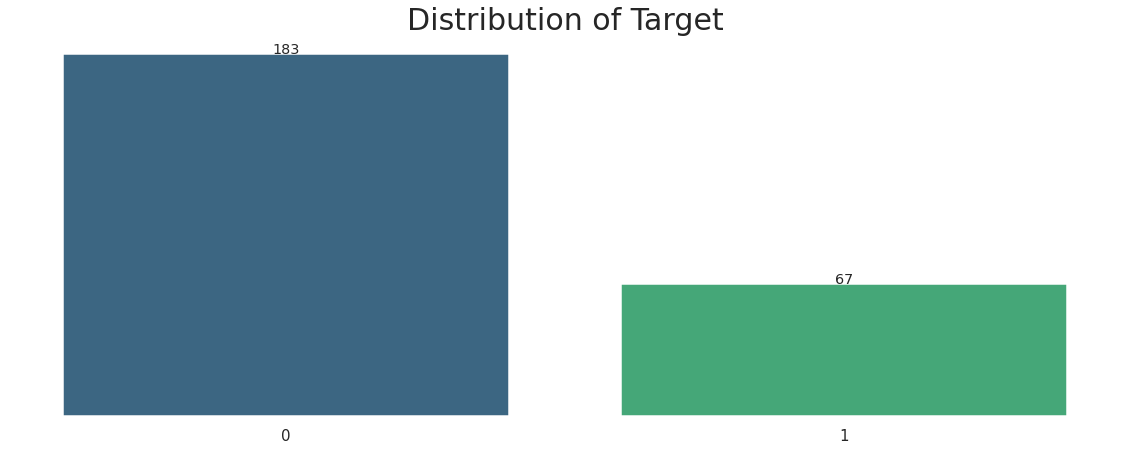

In [99]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(train.target, palette='viridis')
g.set_xticklabels(['0', '1'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Target', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [102]:
lr = LogisticRegression(solver='liblinear')
lr_scores = cross_val_score(lr, recursive_features, y_train, cv=5, scoring='roc_auc')

In [104]:
# feature extraction
rfe = RFE(lr, n_features_to_select=100)

# fit on train set
fit = rfe.fit(X_train, y_train)

# transform train set
recursive_features = fit.transform(X_train)
print('LR Scores: ', lr_scores)

LR Scores:  [0.99206349 0.99603175 0.99168399 0.99376299 0.95841996]


In [107]:
model.fit(X_train, y_train)

print('Model Scores: ', model_scores)

LR Scores:  [0.99206349 0.99603175 0.99168399 0.99376299 0.95841996]


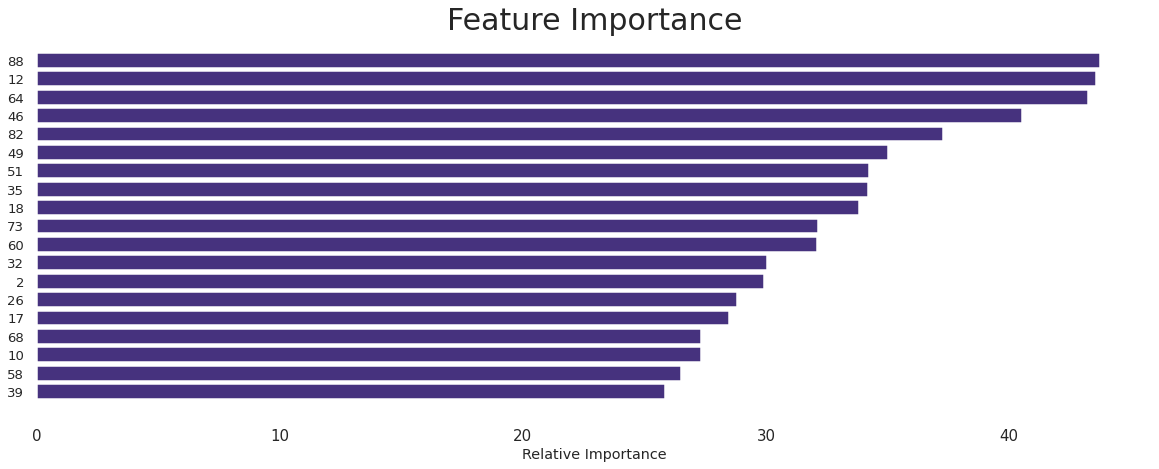

In [105]:
# checking which are the most important features
feature_importance = rfc.fit(recursive_features, y_train).feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:-1:1]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
sns.despine(left=True, bottom=True)
plt.show()

# **SelectFromModel**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

**Create data**

In [ ]:
X = [[ 0.87, -1.34,  0.31, -0.99],
     [-2.79, -0.02, -0.85, 0.5 ],
     [-1.34, -0.48, -2.55, 2.01 ],
     [ 1.92,  1.48,  0.65, 0.95 ]]
y = [0, 1, 0, 1]

Use SelectFromModel to determine which features are more important<br>
True = important feature
False =  not important feature

In [ ]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
print("selector estimator coef: ", selector.estimator_.coef_)
print("selector threshold: ",selector.threshold_)
print("selector get support: ",selector.get_support())

selector estimator coef:  [[-0.32308208  0.81794891  0.51921648  0.06107848]]
selector threshold:  0.4303314870543895
selector get support:  [False  True  True False]


In [ ]:
selector.transform(X)

array([[-1.34,  0.31],
       [-0.02, -0.85],
       [-0.48, -2.55],
       [ 1.48,  0.65]])

# **Tree-based feature selection**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

Load the Iris datset

In [ ]:
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [ ]:
X[1]

array([4.9, 3. , 1.4, 0.2])

Use the trees classifier to determine the important features

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_      

array([0.1037284 , 0.06541328, 0.42891868, 0.40193964])

Create a new dataset that uses only the most important features

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

(150, 2)

In [ ]:
X_new[1]

array([1.4, 0.2])

Tree based example 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

Create synthetic data<br>
>10 features, 3 of them informative


In [ ]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

**Build a forest** and compute the impurity-based feature importances

In [ ]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

**Print the feature ranking**

In [ ]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


**Plot the impurity-based feature importances of the forest**

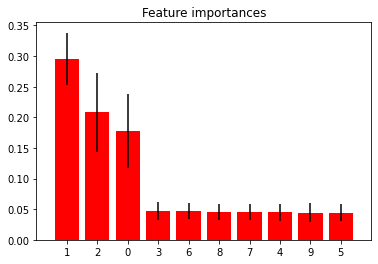

In [ ]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()